## Import necessary modules

In [7]:
import matplotlib.pyplot as plt

from octopus.core import metrics
from octopus.dataset import load_dataset
from octopus.experiments.experiment import trace_elm
from octopus.preprocessing import kernel_builder, compute_grad_image
from octopus.visualization import plotting

import optuna

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the test dataset

In [3]:
scans, base, gt = load_dataset()

## Pick test index and get respective scan, groundtruth ELM, SegNet/Base ELM 

In [36]:
test_idx = 1
test_scan = scans[test_idx]
test_gt = gt[test_idx]
test_base = base[test_idx]

## Compute the gradient image for octopus

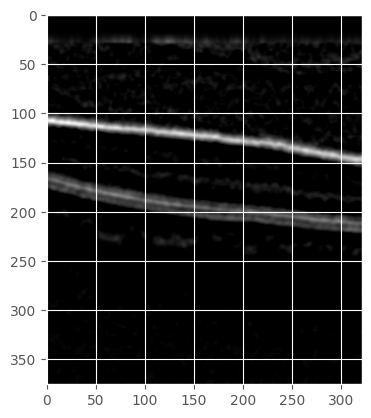

In [37]:
kernel = kernel_builder([21, 5])
test_grad = compute_grad_image(test_scan, kernel)
plt.imshow(test_grad, cmap='gray')

This function is deprecated use: octopus.plotting.display_scan instead


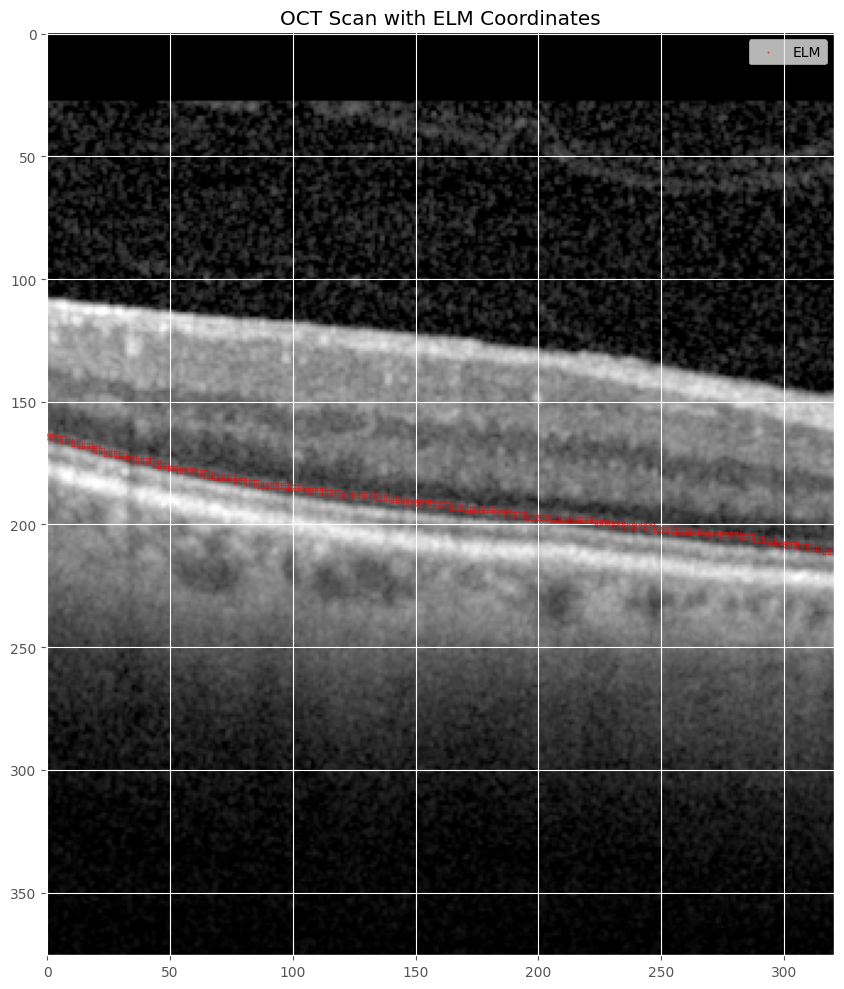

In [38]:
plotting.plot_elm(test_scan, test_gt)

## Hyperparameter Search | Bayesian Optimisation

In [20]:
def objective(trial):
    # Define the hyperparameters to optimize
    num_subsets = trial.suggest_int('num_subsets', 1, 10)
    subset_size = trial.suggest_int('subset_size', 50, 200)
    discontinuity_threshold = trial.suggest_int('discontinuity_threshold', 10, 100)
    buffer = trial.suggest_int('buffer', 1, 10)
    
    # GP params
    gp_params = {
        'kernel_options': {
            'kernel': trial.suggest_categorical('kernel', ['RBF', 'Matern', 'RationalQuadratic']),
            'sigma_f': trial.suggest_float('sigma_f', 0.1, 10.0, log=True),
            'length_scale': trial.suggest_float('length_scale', 0.1, 10.0, log=True),
            'alpha': trial.suggest_float('alpha', 0.1, 10.0, log=True)
        },
        'delta_x': trial.suggest_int('delta_x', 1, 20),
        'score_thresh': trial.suggest_float('score_thresh', 0.1, 1.0),
        'n_samples': trial.suggest_int('n_samples', 100, 2000),
        'seed': trial.suggest_int('seed', 1, 1000),
        'noise_y': trial.suggest_float('noise_y', 0.01, 1.0, log=True),
        'keep_ratio': trial.suggest_float('keep_ratio', 0.05, 0.5),
        'pixel_thresh': trial.suggest_int('pixel_thresh', 1, 20),
        'fix_endpoints': trial.suggest_categorical('fix_endpoints', [True, False]),
        'return_std': True
    }

    # Call your trace_elm function with these hyperparameters
    result = trace_elm(test_grad, test_base, gp_params, num_runs=num_subsets, 
                       discontinuity_threshold=discontinuity_threshold, buffer=buffer)
    
    # Compute Dice to optimise
    dsc = metrics.calculate_dice(result, test_gt, test_grad.shape)
    
    return dsc

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# Create a study object and optimise the objective function
study = optuna.create_study(direction='maximize')  # Find the hyperparameter setting that maximises the Dice coefficient
study.optimize(objective, n_trials=10)

print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-08-07 21:23:34,489] A new study created in memory with name: no-name-cb6564f9-eb3c-44b4-af97-71badc25a027
[I 2024-08-07 21:23:35,863] Trial 0 finished with value: 0.5080527086419616 and parameters: {'num_subsets': 2, 'subset_size': 108, 'discontinuity_threshold': 27, 'buffer': 10, 'kernel': 'RationalQuadratic', 'sigma_f': 0.6875940691843195, 'length_scale': 1.3557435568838974, 'alpha': 0.9485003041026221, 'delta_x': 19, 'score_thresh': 0.333947878961675, 'n_samples': 662, 'seed': 347, 'noise_y': 0.08192507590912244, 'keep_ratio': 0.2835771605284358, 'pixel_thresh': 6, 'fix_endpoints': True}. Best is trial 0 with value: 0.5080527086419616.
[I 2024-08-07 21:23:37,258] Trial 1 finished with value: 0.4754716981171663 and parameters: {'num_subsets': 2, 'subset_size': 152, 'discontinuity_threshold': 30, 'buffer': 9, 'kernel': 'RationalQuadratic', 'sigma_f': 3.1701744887565804, 'length_scale': 1.2440433497974919, 'alpha': 3.4674987531822112, 'delta_x': 20, 'score_thresh': 0.8886200945

Number of finished trials: 100
Best trial:
Value:  0.7253521126776681
Params: 
    num_subsets: 9
    subset_size: 79
    discontinuity_threshold: 27
    buffer: 1
    kernel: Matern
    sigma_f: 5.7105616205075505
    length_scale: 2.506483067319566
    alpha: 8.393831615818957
    delta_x: 12
    score_thresh: 0.6725955912922752
    n_samples: 239
    seed: 259
    noise_y: 0.025132935628299984
    keep_ratio: 0.3361053657852237
    pixel_thresh: 10
    fix_endpoints: True


[I 2024-08-07 21:35:09,154] Trial 0 finished with value: 0.48021828104038056 and parameters: {'num_subsets': 2, 'subset_size': 53, 'discontinuity_threshold': 93, 'buffer': 8, 'kernel': 'Matern', 'sigma_f': 1.5362686214057508, 'length_scale': 0.19647508635848657, 'alpha': 0.14075747294361546, 'delta_x': 16, 'score_thresh': 0.3352388564890251, 'n_samples': 644, 'seed': 557, 'noise_y': 0.35309853265754043, 'keep_ratio': 0.06008814857056749, 'pixel_thresh': 4, 'fix_endpoints': False}. Best is trial 0 with value: 0.48021828104038056.
[I 2024-08-07 21:35:13,866] Trial 1 finished with value: 0.6757594544347442 and parameters: {'num_subsets': 8, 'subset_size': 71, 'discontinuity_threshold': 27, 'buffer': 1, 'kernel': 'RBF', 'sigma_f': 0.8562347705435124, 'length_scale': 1.1697998778169927, 'alpha': 1.207552975846211, 'delta_x': 15, 'score_thresh': 0.43537798033287856, 'n_samples': 516, 'seed': 286, 'noise_y': 0.10824043695886894, 'keep_ratio': 0.27546340601826286, 'pixel_thresh': 13, 'fix_endp

KeyboardInterrupt: 

In [10]:
best_params = study.best_params
best_value = study.best_value

In [21]:
metrics.calculate_dice(test_base, test_gt, test_grad.shape)

0.7467336683429813

## Run OCTOPUS

In [39]:
# Set up the parameters
gp_params = {
    'kernel_options': {
        'kernel': 'Matern',
        'sigma_f': 5.7105616205075505,
        'length_scale': 2.506483067319566,
        'alpha': 8.393831615818957
    },
    'delta_x': 12,
    'score_thresh': 0.6725955912922752,
    'n_samples': 239,
    'seed': 259,
    'noise_y': 0.025132935628299984,
    'keep_ratio': 0.3361053657852237,
    'pixel_thresh': 10,
    'fix_endpoints': True,
    'return_std': True
}

# Call trace_elm with the optimised parameters
result = trace_elm(
    test_grad,
    test_base,
    gp_params=gp_params,
    num_runs=9,
    discontinuity_threshold=27,
    buffer=1,
)

## Plot results

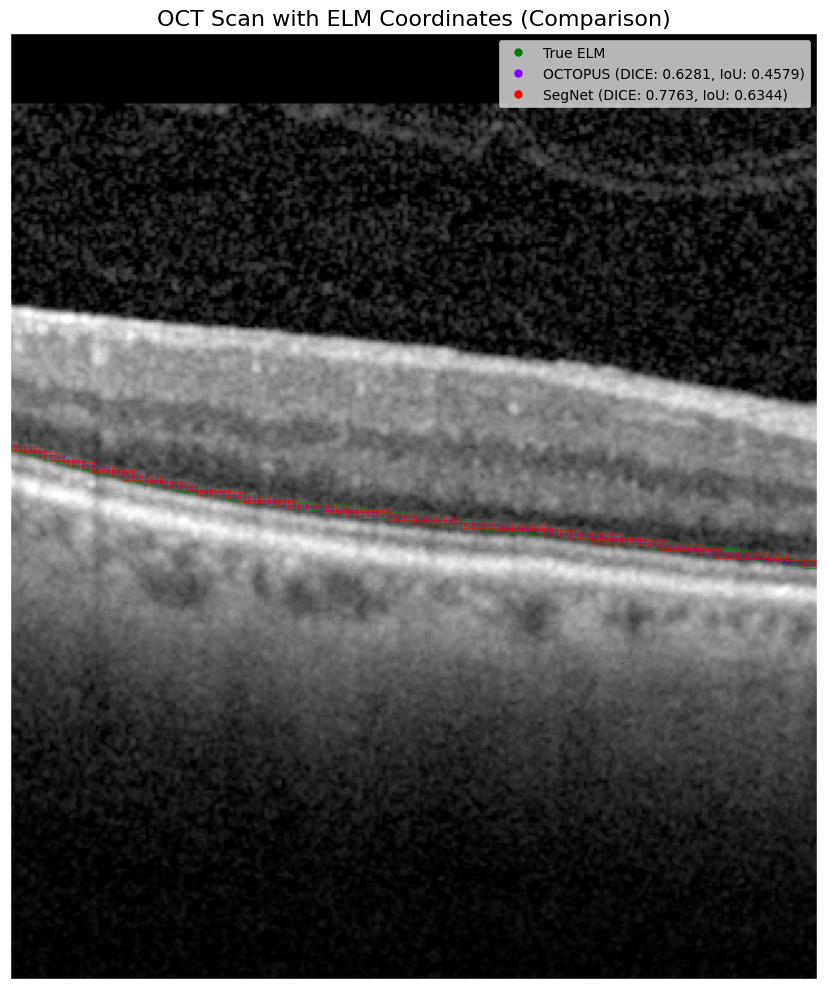

In [40]:
fig = plotting.display_scan(test_scan, {'OCTOPUS': result, 'SegNet': test_base}, gt_elm=test_gt)

## Focused Hyperparameter Search

In [30]:
import optuna

# TEST_IDX = 200
def objective(trial):
    # Define the hyperparameters to optimize
    num_subsets = trial.suggest_int('num_subsets', 25, 75)
    subset_size = trial.suggest_int('subset_size', 100, 300)
    discontinuity_threshold = trial.suggest_int('discontinuity_threshold', 15, 50)
    
    # GP params
    gp_params = {
        'kernel_options': {
            'kernel': trial.suggest_categorical('kernel', ['RBF', 'Matern', 'RationalQuadratic', 'ExpSineSquared']),
            'length_scale': trial.suggest_float('length_scale', 0.1, 10.0, log=True),
            # Keep other kernel parameters fixed
            'sigma_f': 1.0,
            'alpha': 1.0
        },
        'n_samples': trial.suggest_int('n_samples', 100, 2000),
        # Keep other GP parameters fixed
        'delta_x': 10,
        'score_thresh': 0.5,
        'seed': 42,
        'noise_y': 0.1,
        'keep_ratio': 0.3,
        'pixel_thresh': 5,
        'fix_endpoints': True,
        'return_std': True
    }

    # Call your trace_elm function with these hyperparameters
    result = trace_elm(test_grad, test_base, gp_params, 
                       num_runs=num_subsets, 
                       discontinuity_threshold=discontinuity_threshold, 
                       buffer=1)
    
    # Compute metric to optimize (replace with your actual metric)
    metric = metrics.calculate_dice(result, test_gt, test_grad.shape)
    
    return metric

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Number of finished trials:', len(study.trials))
print('Best trial:')

[I 2024-08-07 21:44:55,659] A new study created in memory with name: no-name-703ce606-3178-403a-9de3-6c56ef7c2627
[I 2024-08-07 21:45:01,213] Trial 0 finished with value: 0.581000000002095 and parameters: {'num_subsets': 9, 'subset_size': 111, 'discontinuity_threshold': 61, 'kernel': 'RationalQuadratic', 'length_scale': 0.15479087976139796, 'n_samples': 531}. Best is trial 0 with value: 0.581000000002095.
[I 2024-08-07 21:45:08,888] Trial 1 finished with value: 0.6948245092225174 and parameters: {'num_subsets': 14, 'subset_size': 85, 'discontinuity_threshold': 14, 'kernel': 'RBF', 'length_scale': 1.5530770449316966, 'n_samples': 109}. Best is trial 1 with value: 0.6948245092225174.
[I 2024-08-07 21:45:13,173] Trial 2 finished with value: 0.5778732545672509 and parameters: {'num_subsets': 8, 'subset_size': 107, 'discontinuity_threshold': 99, 'kernel': 'RBF', 'length_scale': 5.11546125147377, 'n_samples': 1884}. Best is trial 1 with value: 0.6948245092225174.
[I 2024-08-07 21:45:46,630] 

Number of finished trials: 50
Best trial:


In [31]:
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Value:  0.7657082002142401
Params: 
    num_subsets: 36
    subset_size: 131
    discontinuity_threshold: 36
    kernel: RationalQuadratic
    length_scale: 0.8014837426994911
    n_samples: 294


In [41]:
# Get the best parameters
best_params = study.best_params

# Use the best parameters to run trace_elm
gp_params = {
    'kernel_options': {
        'kernel': best_params['kernel'],
        'length_scale': best_params['length_scale'],
        'sigma_f': 1.0,
        'alpha': 1.0
    },
    'n_samples': best_params['n_samples'],
    'delta_x': 10,
    'score_thresh': 0.5,
    'seed': 42,
    'noise_y': 0.1,
    'keep_ratio': 0.3,
    'pixel_thresh': 5,
    'fix_endpoints': True,
    'return_std': True
}

best_result = trace_elm(test_grad, test_base, gp_params, 
                        num_runs=50, 
                        discontinuity_threshold=best_params['discontinuity_threshold'], 
                        buffer=1)

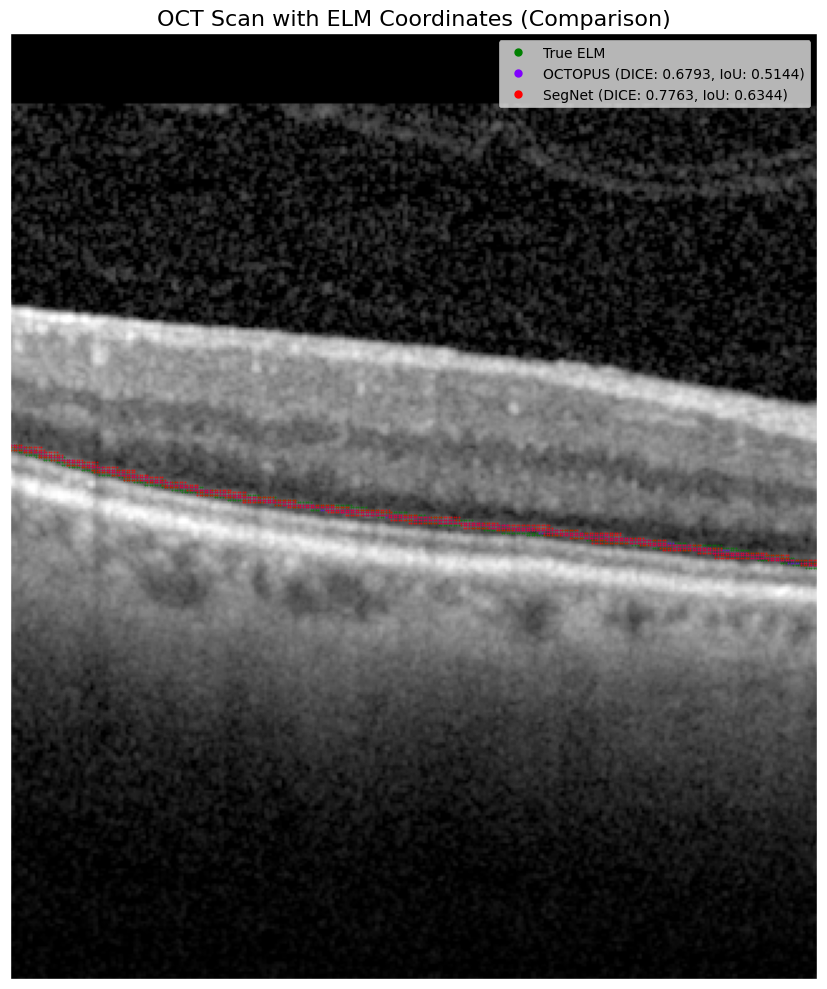

In [42]:
fig = plotting.display_scan(test_scan, {'OCTOPUS': best_result, 'SegNet': test_base}, gt_elm=test_gt)

In [43]:
pred_no_opt = trace_elm(test_grad, test_base, num_runs=100)

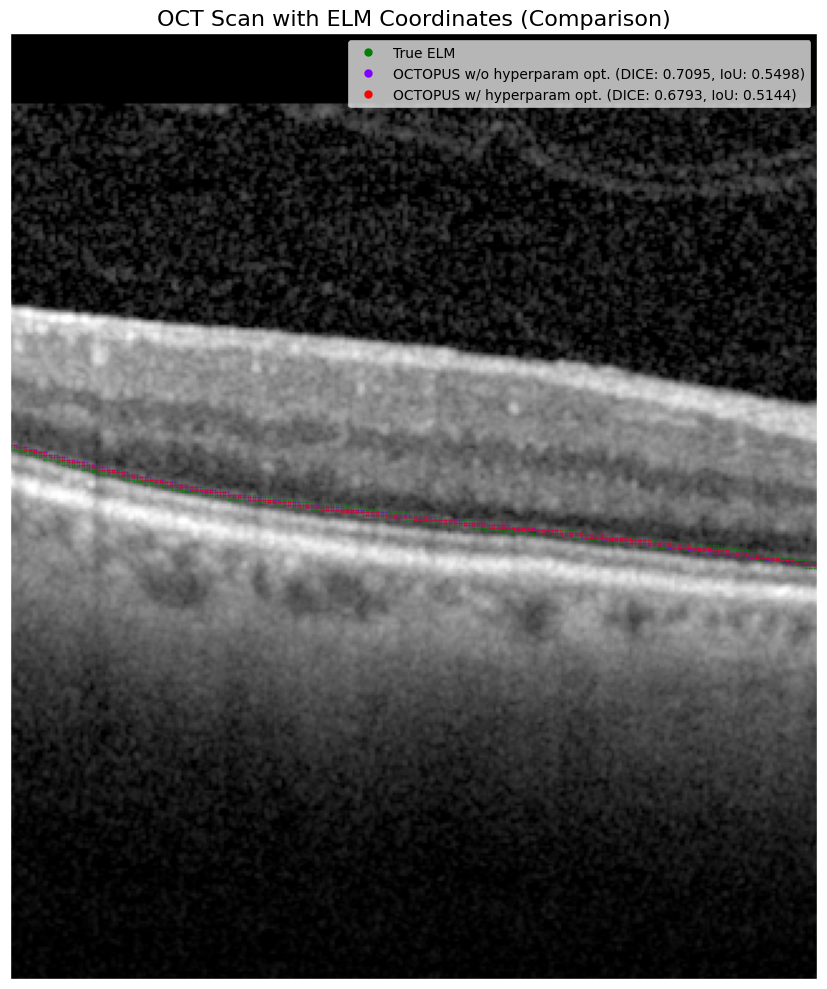

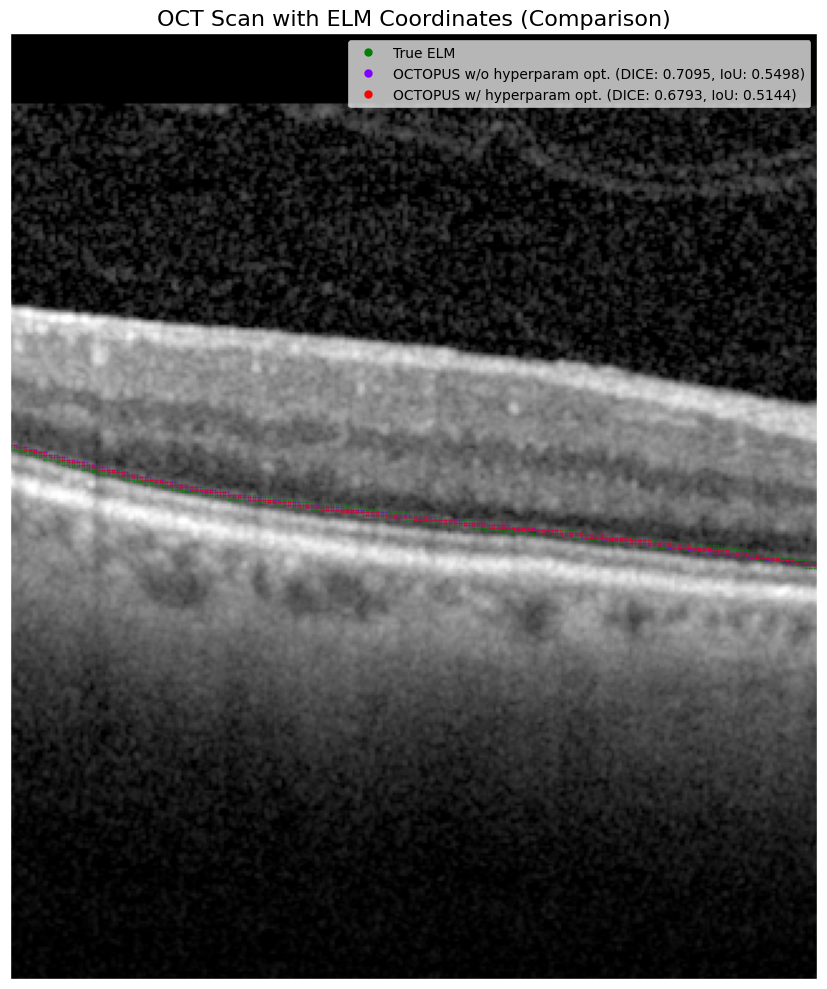

In [44]:
fig = plotting.display_scan(test_scan, {'OCTOPUS w/o hyperparam opt.': pred_no_opt, 'OCTOPUS w/ hyperparam opt.': best_result}, gt_elm=test_gt)